<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-DAG" data-toc-modified-id="The-DAG-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The DAG</a></span></li><li><span><a href="#UI-needs" data-toc-modified-id="UI-needs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>UI needs</a></span></li><li><span><a href="#Scrap" data-toc-modified-id="Scrap-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scrap</a></span></li></ul></div>

We'd like to develop a web app that will help a user to make a domain-specific metric (DSM) to evaluate binary classifiers.

Often, off-the-shelf metrics are used, such as accuracy, precision, recall, false-positive-rate, etc. 

The number these produce may not be directly interpretable in the domain they're being applied to. 

It can be helpful to see what false negative, false positive, etc. mean in the given context, 
and associate a value (penalty or reward) to these 
that reflects how much they contribute towards or contravene the actual objective of the classifier. 

If a COVID test turns out positive, what actions will be taken and what value do their consequences have depending on whether the positive test 
was true or false? Same question for true/false negative test results. Doing this valuation then allows us to produce a formula that
evaluates the worth of a test that has more meaning that flat false positive and false negative rates. 


See this notebook if you want a tutorial on how we came to the DAG we'll use here.

# The DAG

Below are some functions provided to a user
to get from where they are (e.g. they have a model and some test data) 
to where they want to get to (e.g. getting a classifier_score)
is nice.

Making it clear on how to use these functions to get from A to B is also nice.
This can be done through documentation, examples, and (Uncle Bob style) through careful function and variable naming.

In [3]:
from collections import Counter
import numpy as np


def _aligned_items(a, b):
    """Yield (k, a_value, b_value) triples for all k that are both a key of a and of b"""
    # reason for casting to dict is to make sure things like pd.Series use the right keys.
    # could also use k in a.keys() etc. to solve this.
    a = dict(a)
    b = dict(b)
    for k in a:
        if k in b:
            yield k, a[k], b[k]


def _dot_product(a, b):
    """
    >>> dot_product({'a': 1, 'b': 2, 'c': 3}, {'b': 4, 'c': -1, 'd': 'whatever'})
    5
    """
    return sum(ak * bk for _, ak, bk in _aligned_items(a, b))


def classifier_score(confusion_count, confusion_value):
    """Compute a score for a classifier that produced the `confusion_count`, based on the given `confusion_value`.
    Meant to be curried by fixing the confusion_value dict.

    The function is purposely general -- it is not specific to binary classifier outcomes, or even any classifier outcomes. 
    It simply computes a normalized dot product, depending on the inputs keys to align values to multiply and 
    considering a missing key as an expression of a null value. 
    """
    return _dot_product(confusion_count, confusion_value) / sum(confusion_count.values())


def confusion_count(prediction, truth):
    """Get a dict containing the counts of all combinations of predicction and corresponding truth values.
    
    >>> confusion_count(
    ... [0, 0, 1, 0, 1, 1, 1], 
    ... [0, 0, 0, 1, 1, 1, 1]
    ... )
    Counter({(0, 0): 2, (1, 0): 1, (0, 1): 1, (1, 1): 3})
    """
    return Counter(zip(prediction, truth))


def prediction(predict_proba, threshold):
    """Get an array of predictions from thresholding the scores of predict_proba array.
    
    >>> prediction([0.3, 0.4, 0.5, 0.6, 0.7, 0.8], threshold=0.5)
    array([False, False,  True,  True,  True,  True])

    """
    return np.array(predict_proba) >= threshold


def predict_proba(model, test_X):
    """Get the prediction_proba scores of a model given some test data"""
    return model.predict_proba(test_X)


array([False, False,  True,  True,  True,  True])

Conveniently, if we use names of functions and arguments as we did above, these can be used to indicate how they all relate to each other. 

That is to say, we need nothing further to make a DAG.

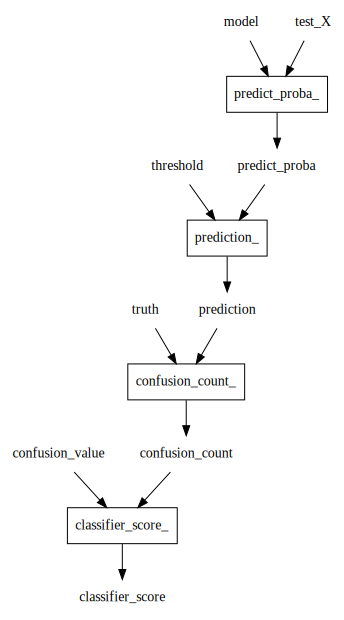

In [4]:
from meshed import DAG

dag = DAG([classifier_score, confusion_count, prediction, predict_proba])
dag.dot_digraph()

# UI needs

So we can use `dagapp` to make an app for this dag, but we'll run into a problem: How do we acquire inputs of complex objects from the user?

Let's start with the `confusion_value` and `confusion_count`. These need to be mapping between some confusion key and a float. 
So we need to allow the user to enter multiple keys and values. 
- Restricting ourselves to binary cases, this means exactly four (though unspecified values can be interpreted as 0. 
- We can find a more general mechanism to allow an arbitrary mapping to be entered.
- The values are floats, but the keys could be complicated. In the case of classification, the keys are actually all possible pairs of categories. 
- There could be a UI component specialized for getting pairs. A matrix makes sense.

To make the dag even more useful, we'll want to vectorize some of the inputs. Namely, we'd like to not enter only one threshold, but possibly a range of them. 

A UI mechanism to get arithmetic sequences would be in order here. Could be:
- min, max, ?all_integers (-> [min, min+1, min+2, ..., max])
- min, max, num_of_elements
- min, max, step

# Scrap